# Import Libraries

In [4]:
# Shawn Schwartz, 2018
# shawnschwartz@ucla.edu
# The Alfaro Lab at UCLA

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering


from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib._png import read_png

import seaborn as sns


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import scipy.spatial.distance as dist
import os
from os import walk, listdir
import warnings
import sys

# Define Functions

In [5]:
# obtain all subdirs of fish
def getFishDirs(file_path):
    randall_fish = [f.path for f in os.scandir(file_path) if f.is_dir()]
    
    return(randall_fish)

def getFishSubDirs(subdirs_path, emptyPaths_array):
    for i in range(len(subdirs_path)):
        for (dirpath, dirnames, filenames) in walk(subdirs_path[i]):
            for j in range(len(filenames)):
                img = dirpath + '/' + filenames[j]
                if "Store" not in img:
                    emptyPaths_array.append(img)
            break
            
    return(emptyPaths_array)

In [6]:
fruits_path = '/Users/shawn/Developer/ML-Fruits/fruit-imgs/'

# Call getFishDirs for Parent Directory and Store
fish_subdirs = getFishDirs(fruits_path)

# Init empty array for individual subdir fish family paths
fish_paths = []

# Call getFishSubDirs for SubDirs and Store
fish_paths = getFishSubDirs(fish_subdirs, fish_paths)

model = VGG16(weights='imagenet', include_top=False)

vgg16_feature_list = []

warnings.filterwarnings('ignore')

def processTheFish(desiredPaths_set, vgg16_model):
    # Print Information for Peace of Mind
    print("Beginning Image Processing for...")
    #print(desiredClusters, " Desired Number of Clusters!")
    
    for i, fname in enumerate(desiredPaths_set):
        # process image files within pre-fetched subdirs
        img = image.load_img(desiredPaths_set[i], target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        
        vgg16_feature = vgg16_model.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)
        vgg16_feature_list.append(vgg16_feature_np.flatten())
        
        # Print image processing progress percentage in console for Peace of Mind
        sys.stdout.write("\r{0}".format((float(i)/len(desiredPaths_set))*100))
        sys.stdout.flush()
        
    print("\nImage Processing Completed!")
    
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    
    return(vgg16_feature_list_np)

def clusterTheFish(desiredClusters, imported_vgg16_feature_list_np):
    kmeans = KMeans(n_clusters=desiredClusters, random_state=0).fit(imported_vgg16_feature_list_np)
    
    print("VGG16 Feature List and KMeans Computed.")
    
    return(kmeans)

def algoClusterFish(desiredClusters, imported_vgg16_feature_list_np):
    algocluster = AgglomerativeClustering(n_clusters=desiredClusters, affinity='euclidean', linkage='ward')  
    algocluster.fit_predict(imported_vgg16_feature_list_np)  
    
    print("AgglomerativeClustering Computed.")
    
    return(algocluster)

def scoreTheFish(imported_Kmeans, imported_vgg16_feature_list_np):
    predicted_labels = imported_Kmeans.labels_
    
    ICV_Score = metrics.silhouette_score(imported_vgg16_feature_list_np, predicted_labels, metric='euclidean')
    
    #altScore = vgg16_model.evaluate(imported_vgg16_feature_list_np, predicted_labels, verbose=0)
   # print('Test Score: ', altScore)
    #print('Test Accuracy: ', altScore[1])
    
    # Print out Internal Cluster Validation Score
    print("\nInternal Cluster Validation Score:", ICV_Score)
    
    # Print out Predicted Cluster ID Labels
    print("\nPredicted Clusters:", predicted_labels)
    
    return(predicted_labels, ICV_Score)

def scoreAlgoFish(imported_algo):
    predicted_labels = imported_algo.labels_
    
    #algo_score = metrics.silhouette_score(imported_vgg16_feature_list_np, predicted_labels, metric='euclidean')
    #return(predicted_labels, algo_score)
    return(predicted_labels)

def writeListToFile(fishy_paths_list, filename):
    # Write the file paths list to its own CSV file
    
    with open(filename, "w") as outfile:
        for entries in fishy_paths_list:
            outfile.write(entries)
            outfile.write("\n")
    
    print("File successfully written to drive: ", filename)
    
def splitTaxonomy(filepaths_files):
    df = pd.read_csv(filepaths_files, names=['paths'], header=None)
    print("Successfully read in file: ", filepaths_files)
    df['family'] = df['paths'].str.split('/').str[6]
    df['tmpgenus'] = df['paths'].str.split('/').str[7]
    df['genus'] = df['tmpgenus'].str.split('_').str[1]
    df['tmpspecies'] = df['paths'].str.split('/').str[7]
    df['species'] = df['tmpspecies'].str.split('_').str[2]
    df['serialnumber'] = df['paths'].str.split('_').str[5]
    
    return(df)

def saveOutputCSV(desClustNums, cluster_output_filename, fish_paths_output_filename, concat_clusters_fishpaths_filename, pred_labels_output, fish_file_paths):
    # temp: write out for pandas concat
    cluster_output_filename =  'DesiredClusters-' + str(desClustNums) + cluster_output_filename
    fish_paths_output_filename = 'DesiredClusters-' + str(desClustNums) + fish_paths_output_filename
    
    # final csv file output
    concat_clusters_fishpaths_filename = 'DesiredClusters-'+ str(desClustNums) + concat_clusters_fishpaths_filename
    
    # temp: for split-apart randall data filenames by taxonomy
   # fish_families_output_filename = 'DesiredClusters-' + str(desClustNums) + fish_families_output_filename
   # fish_genus_output_filename = 'DesiredClusters-' + str(desClustNums) + fish_genus_output_filename
   # fish_species_output_filename = 'DesiredClusters-' + str(desClustNums) + fish_species_output_filename
    
    # save separate CSV files
    np.savetxt(cluster_output_filename, pred_labels_output, delimiter=",")
    writeListToFile(fish_file_paths, fish_paths_output_filename)
    
    tmpdf = splitTaxonomy(fish_paths_output_filename)
    
    #writeListToFile(xxx, fish_families_output_filename)
    #writeListToFile(xxx, fish_genus_output_filename)
    #writeListToFile(xxx, fish_species_output_filename)
    
    # concatenate paths and cluster identification CSVs
    colOne = pd.read_csv(cluster_output_filename, names=['clusterID'], header=None)
    colTwo = pd.read_csv(fish_paths_output_filename, names=['filepaths'], header=None)
    
    colFamily = tmpdf['family']
    colGenus = tmpdf['genus']
    colSpecies = tmpdf['species']
    
    colSerialNumber = tmpdf['serialnumber']
    
    #print(colFamily)
    #print(colGenus)
    #print(colSpecies)
    
    colCat = pd.concat([colTwo, colFamily, colGenus, colSpecies, colSerialNumber, colOne], axis=1)
    #colCat = pd.concat([colTwo, colOne], axis=1)
    colCat.to_csv(concat_clusters_fishpaths_filename, index=False)


    #return(colOne)
    
    tmp_storage = colOne
    
    # remove temp pre-merged single-rowed CSVs from Dir
    os.remove(cluster_output_filename)
    os.remove(fish_paths_output_filename)
    
    return(tmp_storage)

In [7]:
vgg16_fish_featureList_np = processTheFish(fish_paths, model)

np.savetxt("processed_exported_image_feature_list.csv", vgg16_fish_featureList_np, delimiter=",")

Beginning Image Processing for...
99.523809523809524
Image Processing Completed!


In [8]:
clusterOutputFname = "predictedClsts_randall.csv"
fishPathsOutputFname = "fishPaths_randall.csv"
concatClustsFishpathsFname = "overallPredictions_outputData.csv"

In [9]:
#testing algo clustering
algo_des_clusts = 9
nineClusters_algo = algoClusterFish(algo_des_clusts, vgg16_fish_featureList_np)
nineClusters_algo.labels_
output_IDs = saveOutputCSV(algo_des_clusts, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(nineClusters_algo), fish_paths)

testscore = scoreAlgoFish(nineClusters_algo)
testscore
algo_score_testing_nine = metrics.silhouette_score(vgg16_fish_featureList_np, testscore, metric='euclidean')
algo_score_testing_nine


#### GETTING THE DATA FOR HIERARCHICAL CLUSTERING
for iterator in range(2, 21):
    reduced_data = PCA(n_components=2).fit_transform(vgg16_fish_featureList_np)
    kmeans = KMeans(init='k-means++', n_clusters=iterator, n_init=10)
    kmeans.fit(reduced_data)
    centers = kmeans.cluster_centers_
    reduced_data_cat = np.append(reduced_data, output_IDs, 1)
    pca_output_file = "PCA_Data_for_" + str(iterator) + "_clusters.csv"
    np.savetxt(pca_output_file, reduced_data_cat, delimiter=",")    
    centroids_output_file = "PCA_Centroids_Data_for_" + str(iterator) + "_clusters.csv"
    np.savetxt(centroids_output_file, centers, delimiter=",")
    
#manual for cluster 20
iterator = 21
reduced_data = PCA(n_components=2).fit_transform(vgg16_fish_featureList_np)
kmeans = KMeans(init='k-means++', n_clusters=iterator, n_init=10)
kmeans.fit(reduced_data)
centers = kmeans.cluster_centers_
reduced_data_cat = np.append(reduced_data, output_IDs, 1)
pca_output_file = "PCA_Data_for_" + str(iterator) + "_clusters.csv"
np.savetxt(pca_output_file, reduced_data_cat, delimiter=",")    
centroids_output_file = "PCA_Centroids-Data_for_" + str(iterator) + "_clusters.csv"
np.savetxt(centroids_output_file, centers, delimiter=",")

AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-9fishPaths_randall.csv
Successfully read in file:  DesiredClusters-9fishPaths_randall.csv


In [10]:
twoClusters_algo = algoClusterFish(2, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(2, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(twoClusters_algo), fish_paths)

threeClusters_algo = algoClusterFish(3, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(3, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(threeClusters_algo), fish_paths)

fourClusters_algo = algoClusterFish(4, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(4, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(fourClusters_algo), fish_paths)

fiveClusters_algo = algoClusterFish(5, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(5, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(fiveClusters_algo), fish_paths)

sixClusters_algo = algoClusterFish(6, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(6, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(sixClusters_algo), fish_paths)

sevenClusters_algo = algoClusterFish(7, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(7, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(sevenClusters_algo), fish_paths)

eightClusters_algo = algoClusterFish(8, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(8, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(eightClusters_algo), fish_paths)

tenClusters_algo = algoClusterFish(10, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(10, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(tenClusters_algo), fish_paths)

elevenClusters_algo = algoClusterFish(11, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(11, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(elevenClusters_algo), fish_paths)

twelveClusters_algo = algoClusterFish(12, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(12, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(twelveClusters_algo), fish_paths)

thirteenClusters_algo = algoClusterFish(13, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(13, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(thirteenClusters_algo), fish_paths)

fourteenClusters_algo = algoClusterFish(14, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(14, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(fourteenClusters_algo), fish_paths)

fifteenClusters_algo = algoClusterFish(15, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(15, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(fifteenClusters_algo), fish_paths)

sixteenClusters_algo = algoClusterFish(16, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(16, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(sixteenClusters_algo), fish_paths)

seventeenClusters_algo = algoClusterFish(17, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(17, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(seventeenClusters_algo), fish_paths)

eighteenteenClusters_algo = algoClusterFish(18, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(18, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(eighteenteenClusters_algo), fish_paths)

nineteenClusters_algo = algoClusterFish(19, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(19, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(nineteenClusters_algo), fish_paths)

twentyClusters_algo = algoClusterFish(20, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(20, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(twentyClusters_algo), fish_paths)

twentyOneClusters_algo = algoClusterFish(21, vgg16_fish_featureList_np)
output_IDs = saveOutputCSV(21, clusterOutputFname, fishPathsOutputFname, concatClustsFishpathsFname, scoreAlgoFish(twentyOneClusters_algo), fish_paths)



AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-2fishPaths_randall.csv
Successfully read in file:  DesiredClusters-2fishPaths_randall.csv
AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-3fishPaths_randall.csv
Successfully read in file:  DesiredClusters-3fishPaths_randall.csv
AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-4fishPaths_randall.csv
Successfully read in file:  DesiredClusters-4fishPaths_randall.csv
AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-5fishPaths_randall.csv
Successfully read in file:  DesiredClusters-5fishPaths_randall.csv
AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-6fishPaths_randall.csv
Successfully read in file:  DesiredClusters-6fishPaths_randall.csv
AgglomerativeClustering Computed.
File successfully written to drive:  DesiredClusters-7fishPaths_randall.csv
Succe

[0.14021023, 0.053141158, 0.055409662, 0.038949657, 0.044570316, 0.043553207, 0.040451776, 0.02142286, 0.025805525, 0.028649248, 0.031910338, 0.03453729, 0.0346418, 0.037303295, 0.036873545, 0.04021122, 0.041515358, 0.043849908, 0.04538213, 0.046732306]
20


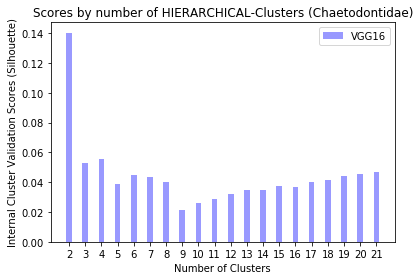

In [11]:
# hierarchical scoring separate from function due to array dimensional errors
score_two = scoreAlgoFish(twoClusters_algo)
algo_score_two = metrics.silhouette_score(vgg16_fish_featureList_np, score_two, metric='euclidean')

score_three = scoreAlgoFish(threeClusters_algo)
algo_score_three = metrics.silhouette_score(vgg16_fish_featureList_np, score_three, metric='euclidean')

score_four = scoreAlgoFish(fourClusters_algo)
algo_score_four = metrics.silhouette_score(vgg16_fish_featureList_np, score_four, metric='euclidean')

score_five = scoreAlgoFish(fiveClusters_algo)
algo_score_five = metrics.silhouette_score(vgg16_fish_featureList_np, score_five, metric='euclidean')

score_six = scoreAlgoFish(sixClusters_algo)
algo_score_six = metrics.silhouette_score(vgg16_fish_featureList_np, score_six, metric='euclidean')

score_seven = scoreAlgoFish(sevenClusters_algo)
algo_score_seven = metrics.silhouette_score(vgg16_fish_featureList_np, score_seven, metric='euclidean')

score_eight = scoreAlgoFish(eightClusters_algo)
algo_score_eight = metrics.silhouette_score(vgg16_fish_featureList_np, score_eight, metric='euclidean')

score_nine = scoreAlgoFish(nineClusters_algo)
algo_score_nine = metrics.silhouette_score(vgg16_fish_featureList_np, score_nine, metric='euclidean')

score_ten = scoreAlgoFish(tenClusters_algo)
algo_score_ten = metrics.silhouette_score(vgg16_fish_featureList_np, score_ten, metric='euclidean')

score_eleven = scoreAlgoFish(elevenClusters_algo)
algo_score_eleven = metrics.silhouette_score(vgg16_fish_featureList_np, score_eleven, metric='euclidean')

score_twelve = scoreAlgoFish(twelveClusters_algo)
algo_score_twelve = metrics.silhouette_score(vgg16_fish_featureList_np, score_twelve, metric='euclidean')

score_thirteen = scoreAlgoFish(thirteenClusters_algo)
algo_score_thirteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_thirteen, metric='euclidean')

score_fourteen = scoreAlgoFish(fourteenClusters_algo)
algo_score_fourteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_fourteen, metric='euclidean')

score_fifteen = scoreAlgoFish(fifteenClusters_algo)
algo_score_fifteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_fifteen, metric='euclidean')

score_sixteen = scoreAlgoFish(sixteenClusters_algo)
algo_score_sixteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_sixteen, metric='euclidean')

score_seventeen = scoreAlgoFish(seventeenClusters_algo)
algo_score_seventeen = metrics.silhouette_score(vgg16_fish_featureList_np, score_seventeen, metric='euclidean')

score_eighteen = scoreAlgoFish(eighteenteenClusters_algo)
algo_score_eighteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_eighteen, metric='euclidean')

score_nineteen = scoreAlgoFish(nineteenClusters_algo)
algo_score_nineteen = metrics.silhouette_score(vgg16_fish_featureList_np, score_nineteen, metric='euclidean')

score_twenty = scoreAlgoFish(twentyClusters_algo)
algo_score_twenty = metrics.silhouette_score(vgg16_fish_featureList_np, score_twenty, metric='euclidean')

score_twentyOne = scoreAlgoFish(twentyOneClusters_algo)
algo_score_twentyOne = metrics.silhouette_score(vgg16_fish_featureList_np, score_twentyOne, metric='euclidean')

clusterScoring = []
clusterScoring.append(algo_score_two)
clusterScoring.append(algo_score_three)
clusterScoring.append(algo_score_four)
clusterScoring.append(algo_score_five)
clusterScoring.append(algo_score_six)
clusterScoring.append(algo_score_seven)
clusterScoring.append(algo_score_eight)
clusterScoring.append(algo_score_nine)
clusterScoring.append(algo_score_ten)
clusterScoring.append(algo_score_eleven)
clusterScoring.append(algo_score_twelve)
clusterScoring.append(algo_score_thirteen)
clusterScoring.append(algo_score_fourteen)
clusterScoring.append(algo_score_fifteen)
clusterScoring.append(algo_score_sixteen)
clusterScoring.append(algo_score_seventeen)
clusterScoring.append(algo_score_eighteen)
clusterScoring.append(algo_score_nineteen)
clusterScoring.append(algo_score_twenty)
clusterScoring.append(algo_score_twentyOne)



print(clusterScoring)
print(len(clusterScoring))

#temp plotting (TODO: Make recursive)
#n_groups = 19
n_groups = len(clusterScoring)

#clusterICVScores_Means = (twoClusters_ICVScore, threeClusters_ICVScore, fourClusters_ICVScore, fiveClusters_ICVScore, sixClusters_ICVScore, sevenClusters_ICVScore,
                       #  eightClusters_ICVScore, nineClusters_ICVScore, tenClusters_ICVScore, elevenClusters_ICVScore, twelveClusters_ICVScore,
                       #  thirteenClusters_ICVScore, fourteenClusters_ICVScore, fifteenClusters_ICVScore, sixteenClusters_ICVScore, seventeenClusters_ICVScore,
                       #  eighteenClusters_ICVScore, nineteenClusters_ICVScore, twentyClusters_ICVScore)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, clusterScoring, bar_width,
                alpha=opacity, color='b', 
                error_kw=error_config,
                label='VGG16')


ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Internal Cluster Validation Scores (Silhouette)')
ax.set_title('Scores by number of HIERARCHICAL-Clusters (Chaetodontidae)')
ax.set_xticks(index)
ax.set_xticklabels(('2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'))
#ax.set_xticklabels(('2', '3', '4', '5'))
ax.legend()

fig.tight_layout()
plt.draw()
plt.show()


fig.savefig('ICV_Scoring.jpg', dpi=100)

icvscore_output_file = "Silhouette_Scores.csv"
np.savetxt(icvscore_output_file, clusterScoring, delimiter=",")

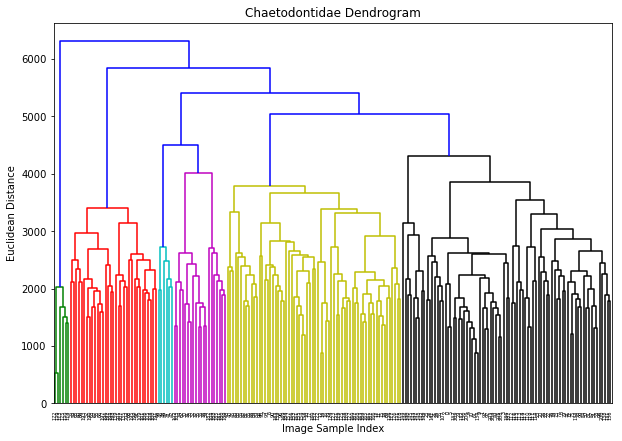

In [12]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Chaetodontidae Dendrogram")  
plt.xlabel('Image Sample Index')
plt.ylabel('Euclidean Distance')
dend = shc.dendrogram(shc.linkage(vgg16_fish_featureList_np, method='ward'))
plt.savefig('Dendrogram.jpg', dpi=100)